# Dynamic mode decomposition with control on a high-dimensional, linear system sparse in the Fourier space
Dynamic mode decomposition with control (DMDc) aims to disambiguate the effect of control/actuation
from the unforced dynamics.
We apply DMDc to a high-dimensional, linear system,
which intrinsic dynamics are low-dimensional in Fourier space
(this is example 3 in Sec. 4 in Proctor et al., _"Dynamic Mode Decomposition with Control"_, SIAM 2016).

$$x_{k+1} =Ax_k + B u_k,\quad y_k = Cx_k$$

We first import the pyKoopman package and other packages for plotting and matrix manipulation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.gridspec import GridSpec

import pykoopman as pk

Define few, active frequency components that characterize the system.

In [40]:

np.random.seed(1) # for reproducibility

show_movie = 0
sparsity = 5   # degree of sparsity
n_states = 128 # number of states
T = 4          # integration time
dt = 0.02      # time step
n_samples = int(T/dt)
r = 10
freq_max = 15

xhat = np.zeros((n_states,n_states), complex)
I = np.zeros(sparsity, dtype=int) # Index of nonzero frequency components
J = np.zeros(sparsity, dtype=int)
IC = np.zeros(sparsity)           # Initial condition
frequencies = np.zeros(sparsity)
damping = np.zeros(sparsity)

# IC = np.array([0.3426, 0.7254, 1.4897, 0.7172, -0.3034])
# frequencies = np.array([1.9570, 1.3934, 1.7801, 1.9329, 1.6192])
# damping = np.array([-0.0965, -0.0800, -0.0959, -0.0679, -0.0171])
# I = np.array([1, 2, 2, 6, 7], int)
# J = np.array([3, 9, 4, 1, 7], int) 

IC = np.random.randn(sparsity)
frequencies = np.sqrt(4*np.random.rand(sparsity))
damping = -np.random.rand(sparsity)*0.1
for i in range(sparsity):
    loopbreak = 0;
    while loopbreak is not 1:
        I[i] = np.ceil(np.random.rand(1)*n_states/(freq_max+1))
        J[i] = np.ceil(np.random.rand(1)*n_states/(freq_max+1))
        if xhat[I[i],J[i]] == 0.0:
            loopbreak = 1

    xhat[I[i],J[i]] = IC[i]
 
mask = np.zeros((n_states,n_states), int)
for k in range(sparsity):
    mask[I[k],J[k]] = 1

Show component values and initial conditions.

In [41]:
print('Damping coefficients: ', damping)
print('Frequencies: ', frequencies)
print('Initial values: ',IC)

Damping coefficients:  [-0.06704675 -0.04173048 -0.05586898 -0.01403869 -0.01981015]
Frequencies:  [1.29490465 1.65555972 0.90432793 1.87415841 0.33098395]
Initial values:  [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]


Generate high-dimensional (and noise-corrupted) data, for which the underlying low-dimensional dynamics are governed by the above Fourier components.

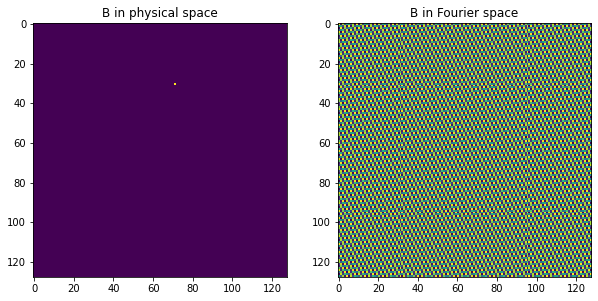

In [42]:
noisemag = 0.0

# Control matrix in physical space (single point actuator)
B = np.zeros((n_states, n_states))
B[np.random.randint(0, n_states, 1), np.random.randint(0, n_states, 1)] = 1

fig = plt.figure(figsize=(10,20))
ax1 = plt.subplot2grid((1,2),(0,0), title='B in physical space')
ax1.imshow(np.real(B),interpolation='none', aspect='equal')

# Control matrix in Fourier space
Bhat = np.fft.fft2(B)

ax1 = plt.subplot2grid((1,2),(0,1), title='B in Fourier space')
ax1.imshow(np.real(Bhat),interpolation='none', aspect='equal')

# Random control inputs
U = np.random.rand(n_samples)

# Initilization
X = np.ndarray((n_states**2, n_samples)) # In physical space
Xhat = np.ndarray((n_states**2, n_samples), complex) # In Fourier space
Xnoise = np.ndarray((n_states**2, n_samples))
XhatNoise = np.ndarray((n_states**2, n_samples), complex)
Xhat_unforced = np.ndarray((n_states**2, n_samples), complex) # I


t = 0
for step in range(n_samples):
    t = step*dt
    xhat_unforced = np.zeros((n_states,n_states))
    for k in range(sparsity):
        xhat_unforced[I[k],J[k]] = np.exp(damping[k]*t)*np.cos(2*np.pi*frequencies[k]*t)*IC[k] \
                                    + 1j*np.exp(damping[k]*t)*np.sin(2*np.pi*frequencies[k]*t)*IC[k]

    if t==0:
        xhat_dt = np.zeros((n_states,n_states))
        for k in range(sparsity):
            xhat_dt[I[k],J[k]] = IC[k]

    else:
        Xhat[:,step] = np.reshape(Bhat*U[step-1],n_states**2)
        xhat = Xhat[:,step].reshape(n_states,n_states)
        xhat_prev = Xhat[:,step-1].reshape(n_states,n_states)
        for k in range(sparsity):
            xhat[I[k],J[k]] += np.exp((damping[k]+1j*2*np.pi*frequencies[k])*dt)*xhat_prev[I[k],J[k]]

    Xhat_unforced[:,step] = xhat_unforced.reshape(n_states**2)
    Xhat[:,step] = xhat.reshape(n_states**2)
    xRMS = np.sqrt(np.mean(xhat.reshape((n_states**2,1))**2))
    xhatNoise = xhat + noisemag*xRMS*np.random.randn(xhat.shape[0],xhat.shape[1]) \
                + 1j*noisemag*xRMS*np.random.randn(xhat.shape[0],xhat.shape[1])
    XhatNoise[:,step] = xhatNoise.reshape(n_states**2)
    x = np.real(np.fft.ifft2(xhat))
    X[:,step] = x.reshape(n_states**2)

Visualize non-zero frequency components.

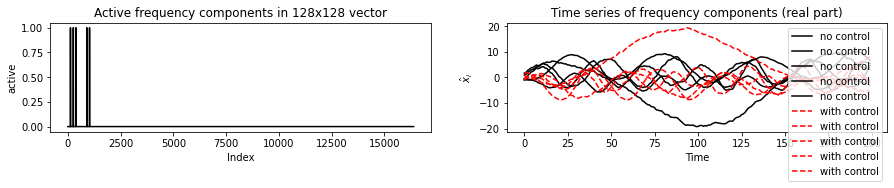

In [43]:
xhat_nonzero = Xhat[mask.reshape(n_states**2)==1,:]
xhat_dt_nonzero = Xhat_dt[mask.reshape(n_states**2)==1,:]


fig = plt.figure(figsize=(15, 2))
ax = fig.add_subplot(121, title = 'Active frequency components in 128x128 vector')
ax.plot(mask.reshape(n_states**2),'-', color='black')
ax.set(ylabel=r'active', xlabel='Index')

ax = fig.add_subplot(122, title = 'Time series of frequency components (real part)')
ax.plot(np.real(xhat_nonzero.T),'-', color='black', label='no control')
ax.set(ylabel=r'$\hat{x}_i$', xlabel='Time')
ax.plot(np.real(xhat_dt_nonzero.T),'--', color='red', label='with control')
# ax.set(ylabel=r'$\hat{x}_i$', xlabel='Time')
ax.legend()

Some helper functions to help us visualize the data.

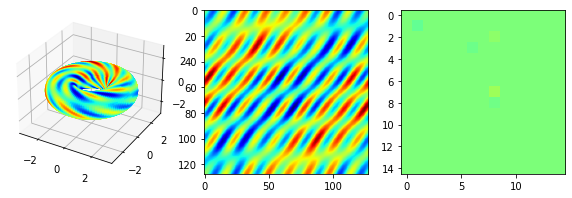

In [44]:
cmap_torus = plt.cm.jet #bwr #plt.cm.RdYlBu

cmax = abs(X).max()
cmaxhat = abs(np.real(Xhat)).max()

n_colors = 128
n,_ = x.shape
r1 = 2
r2 = 1
[T1,T2] = np.meshgrid(np.linspace(0,2*np.pi,n), np.linspace(0,2*np.pi,n))
R = r1 + r2*np.cos(T2)
Zgrid = r2*np.sin(T2)
Xgrid = R*np.cos(T1)
Ygrid = R*np.sin(T1)
    
def viz_torus(ax,x):
    norm = mpl.colors.Normalize(vmin=-abs(x).max(), vmax=abs(x).max()) 
    surface = ax.plot_surface(Xgrid, Ygrid, Zgrid, facecolors=cmap_torus(norm(x)), shade=False, rstride=1, cstride=1)
#     m = cm.ScalarMappable(cmap=cmap_torus, norm=norm)
#     m.set_array([])
#     plt.colorbar(m)
    # ax.figure.colorbar(surf, ax=ax)
    ax.set_zlim(-3.01, 3.01)
    return surface

fig = plt.figure(figsize=(10,30))

ax1 = plt.subplot2grid((1,3),(0,0),projection='3d')
viz_torus(ax1, X[:,0].reshape(n_states,n_states))

ax2 = plt.subplot2grid((1,3),(0,1))
ax2.imshow(X[:,0].reshape(n_states,n_states),cmap=cmap_torus)

ax3 = plt.subplot2grid((1,3),(0,2))
xhattmp = Xhat[:,0].reshape(n_states,n_states)
ax3.imshow(np.real(xhattmp[:freq_max,:freq_max]),interpolation='none', aspect='equal', 
                 vmax=cmaxhat, vmin=-cmaxhat, animated=True, cmap=cmap_torus)

Create animation of dataset, in particular of the activity in Fourier space and corresponding spatial information.

Max number of frames:  10


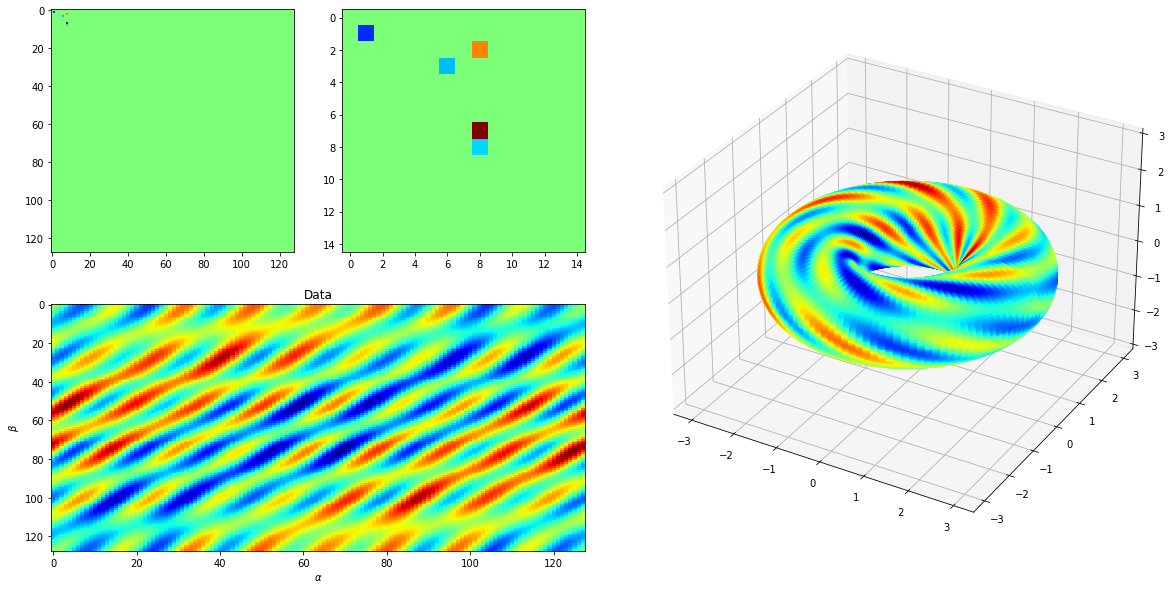

In [7]:
frame_step = 1
n_frames_max = 10

# n_frames_max = min([int(np.floor(n_samples/frame_step)),n_frames_max])
print('Max number of frames: ', n_frames_max)

fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((2,4),(1,0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((2,4),(0,0))
ax3 = plt.subplot2grid((2,4),(0,1))
ax4 = plt.subplot2grid((2,4),(0,2), projection='3d', colspan=2, rowspan=2)

ax1.set_title('Data')
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel(r'$\beta$')

xtmp = X[:,0].reshape(n_states, n_states)
im1 = ax1.imshow(xtmp,interpolation='none', vmax=cmax, vmin=-cmax, animated=True, cmap=cmap_torus, aspect='auto')

xhattmp = Xhat[:,0].reshape(n_states, n_states)
im2 = ax2.imshow(np.real(xhattmp),interpolation='none', aspect='equal', 
                 vmax=cmaxhat, vmin=-cmaxhat, animated=True, cmap=cmap_torus)
im3 = ax3.imshow(np.real(xhattmp[:freq_max,:freq_max]),interpolation='none', aspect='equal', 
                 vmax=cmaxhat, vmin=-cmaxhat, animated=True, cmap=cmap_torus)

im4 = viz_torus(ax4,xtmp)


def animate(frame):
    xtmp = X[:,frame_step*frame].reshape(n_states, n_states)
    im1.set_data(xtmp)
    
    xhattmp = np.real(Xhat[:,frame].reshape(n_states, n_states))
    im2.set_data(xhattmp)
    im3.set_data(xhattmp[:freq_max,:freq_max])
    
    im4 = viz_torus(ax4,xtmp)

    return [im1, im2, im3, im4]

if show_movie == 1:
    anim = animation.FuncAnimation(fig, animate,
                                   frames=n_frames_max, interval=20, blit=True) #n_samples
    # plt.close(anim._fig)
    # HTML(anim.to_html5_video())
    HTML(anim.to_jshtml())
    # anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    
plt.show()


Compute true modes

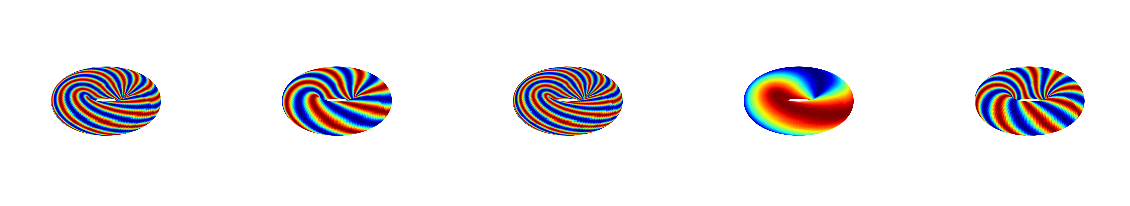

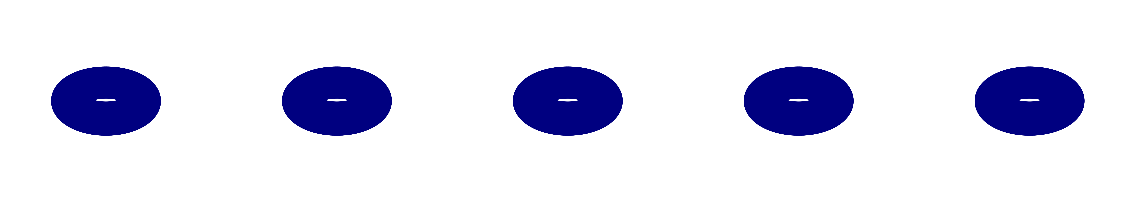

In [50]:
PhiTrue = np.zeros((n_states**2,sparsity))

for k in range(sparsity):
    mode_in_fourier = np.zeros((n_states,n_states))
    mode_in_fourier[I[k],J[k]] = 1
    PhiTrue[:,k] = np.real(np.fft.ifft2(mode_in_fourier).reshape(n_states**2))

def plot_all_modes_on_torus(modes):    
    fig = plt.figure(figsize=(20,10))
    for k in range(sparsity):
        ax = plt.subplot2grid((1,sparsity),(0,k), projection='3d')
        tmp = modes[:,k].reshape(n_states,n_states)
        viz_torus(ax,tmp)
        plt.axis('off')


plot_all_modes_on_torus(np.real(PhiTrue))
plot_all_modes_on_torus(np.imag(PhiTrue))

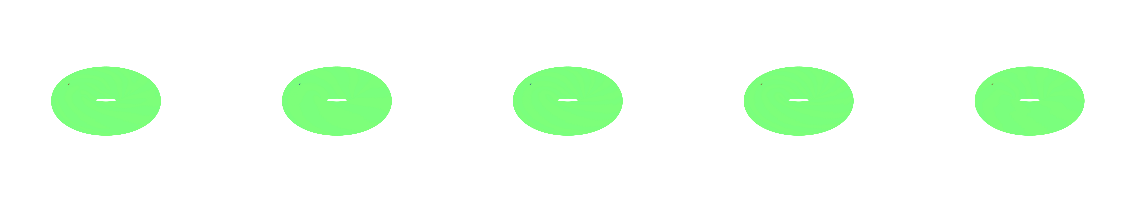

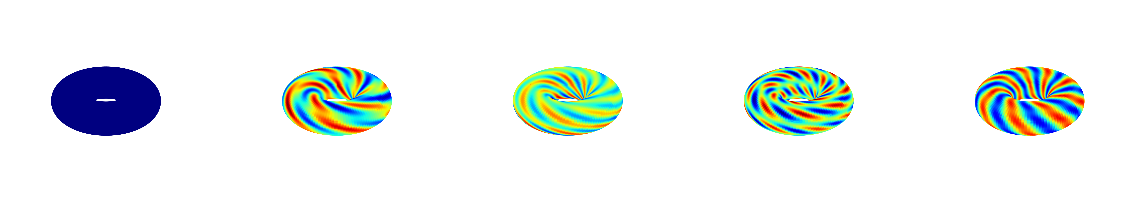

In [51]:
from pydmd import DMD
dmd = DMD(svd_rank=2*sparsity)
model = pk.Koopman(regressor=dmd)
model.fit(X.T)

Phi = model.regressor.regressor.modes
plot_all_modes_on_torus(np.real(Phi[:,::2]))
plot_all_modes_on_torus(np.imag(Phi[:,::2])) # every other mode as they come in pairs


# X2 = X[:,-1]
# K = model.koopman_matrix.real
# evals, W = np.linalg.eig(K)
# Phi = X2*Vr*inv(Sr)*U1.T*Uhatr*W
# evals_cont = np.log(evals)/dt


In [10]:
# from pykoopman.common  import drss, advance_linear_system
#
# n_states = 5
# n_controls = 2
# n_measurements = 50
# A,B,C = drss(n_states, n_controls, n_measurements)
#
# x0 = np.array([4,7,2,8,0])
# u = np.array([[-4, -2, -1, -0.5, 0, 0.5, 1, 3, 5, 9,
#                8, 4, 3.5, 1, 2, 3, 1.5, 0.5, 0, 1,
#                -1, -0.5, -2, -4, -5, -7, -9, -6, -5, -5.5],
#               [4, 1, -1, -0.5, 0, 1, 2, 4, 3, 1.5,
#                1, 0, -1, -1.5, -2, -1, -3, -5, -9, -7,
#                -5, -6, -8, -6, -4, -3, -2, -0.5, 0.5, 3]])
# n = u.shape[1]
# X,Y = advance_linear_system(x0,u,n,A,B,C)
# U = u.transpose()

